## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
c:\users\henry\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\henry\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\henry\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [18]:
import tensorflow as tf
import keras.backend as K
from keras import losses
"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
loss function, 為 0.3 * focal loss + 0.7 cross-entropy
"""
def combined_loss():
    def binary_focal_loss_fixed(y_true, y_pred):
        alpha = tf.constant(0.25, dtype=tf.float32)
        gamma = tf.constant(2, dtype=tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        cross_entropy = losses.categorical_crossentropy(y_true, y_pred)
        loss = tf.add(tf.multiply(0.3,focal_loss), K.mean(tf.multiply(0.7,cross_entropy)))
        return loss
    return binary_focal_loss_fixed
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [19]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(), 
                  metrics=["accuracy"],
                  optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128) 

50000/50000 [==============================] - 10s 207us/step - loss: 0.9322 - acc: 0.5426 - val_loss: 1.0668 - val_acc: 0.4736
Epoch 13/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.9164 - acc: 0.5525 - val_loss: 1.0573 - val_acc: 0.4754
Epoch 14/25
50000/50000 [==============================] - 10s 204us/step - loss: 0.9008 - acc: 0.5598 - val_loss: 1.0624 - val_acc: 0.4750
Epoch 15/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.8864 - acc: 0.5670 - val_loss: 1.0603 - val_acc: 0.4749
Epoch 16/25
50000/50000 [==============================] - 10s 204us/step - loss: 0.8718 - acc: 0.5739 - val_loss: 1.0490 - val_acc: 0.4797
Epoch 17/25
50000/50000 [==============================] - 11s 222us/step - loss: 0.8579 - acc: 0.5826 - val_loss: 1.0436 - val_acc: 0.4849
Epoch 18/25
50000/50000 [==============================] - 10s 201us/step - loss: 0.8440 - acc: 0.5887 - val_loss: 1.0422 - val_acc: 0.4842
Epoch 19/25
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 15s 300us/step - loss: 1.6402 - acc: 0.2432 - val_loss: 1.5746 - val_acc: 0.2776
Epoch 2/25
50000/50000 [==============================] - 10s 199us/step - loss: 1.2874 - acc: 0.3652 - val_loss: 1.3654 - val_acc: 0.3460
Epoch 3/25
50000/50000 [==============================] - 10s 203us/step - loss: 1.1898 - acc: 0.4116 - val_loss: 1.2533 - val_acc: 0.38970.41
Epoch 4/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.1343 - acc: 0.4389 - val_loss: 1.2014 - val_acc: 0.4166
Epoch 5/25
50000/50000 [==============================] - 10s 194us/step - loss: 1.0946 - acc: 0.4609 - val_loss: 1.1657 - val_acc: 0.4236
Epoch 6/25
50000/50000 [==============================] - 10s 194us/step - loss: 1.0626 - acc: 0.4747 - val_loss: 1.1423 - val_acc: 0.4420
Epoch 7/25
50000/50000 [==============================] - 10s 207us/step - loss: 1.0345 - acc: 0.4885 - val_loss:

50000/50000 [==============================] - 10s 200us/step - loss: 0.7732 - acc: 0.6255 - val_loss: 1.0344 - val_acc: 0.4856
Epoch 24/25
50000/50000 [==============================] - 10s 193us/step - loss: 0.7610 - acc: 0.6329 - val_loss: 1.0337 - val_acc: 0.4885
Epoch 25/25
50000/50000 [==============================] - 10s 192us/step - loss: 0.7487 - acc: 0.6399 - val_loss: 1.0316 - val_acc: 0.4936


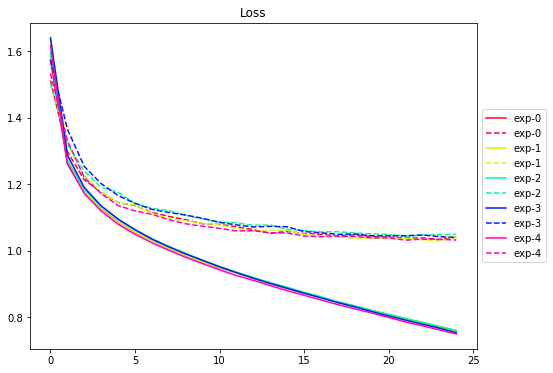

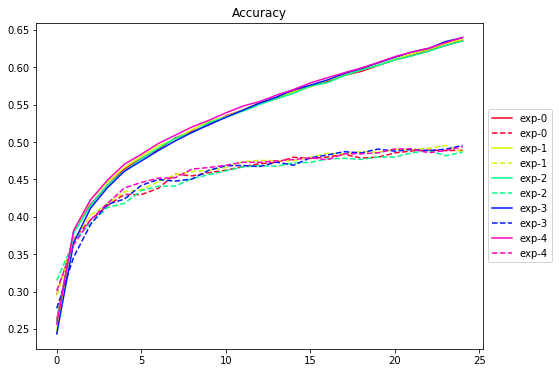

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()